In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re

/var/folders/11/nm6kpssd7xzgy74kn2x39xx80000gn/T/ipykernel_27385/2797650847.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [61]:
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols 
import scipy.stats as ss
import plotly.express as px

In [3]:
os.getcwd()

'/Users/tobias/Git/gds'

In [4]:
btw_df = pd.read_csv('Data/btw21_wbz/btw21_wbz_ergebnisse.csv', delimiter=';', header=None)

btw_df.columns = [str(i) + ' ' + str(j) if j is not np.nan else str(i) for i,j in zip(btw_df.loc[[0]].values.flatten(), btw_df.loc[[1]].values.flatten())]

btw_df = btw_df.drop([0,1])

btw_df = btw_df[btw_df['Land'] == '02']

btw_df = btw_df.drop(btw_df.columns[list(range(11,65))], axis = 1)
btw_df = btw_df.drop(btw_df.columns[list(range(18,53))], axis = 1)
btw_df = btw_df.drop(btw_df.columns[list(range(4,11))], axis = 1)
btw_df = btw_df.drop(btw_df.columns[list(range(0,3))], axis = 1)

btw_df.columns = [
    re.sub(' ', '_', 
    re.sub(' zweitstimmen', '', 
    str.lower(x))) for x in btw_df.columns]

btw_df.columns

/var/folders/11/nm6kpssd7xzgy74kn2x39xx80000gn/T/ipykernel_27385/2880464049.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  btw_df = pd.read_csv('Data/btw21_wbz/btw21_wbz_ergebnisse.csv', delimiter=';', header=None)


Index(['kreis', 'gültige', 'cdu', 'spd', 'afd', 'fdp', 'die_linke', 'grüne'], dtype='object')

In [5]:
btw_df[
       ['gültige', 'cdu', 'spd', 'afd', 'fdp', 'die_linke', 'grüne']
       ] = btw_df[
       ['gültige', 'cdu', 'spd', 'afd', 'fdp', 'die_linke','grüne']
       ].apply(pd.to_numeric, errors = 'coerce')

btw_df['sonstige'] = btw_df.apply(lambda x: int(x.gültige) - sum([x.cdu, x.spd, x.afd, x.fdp, x.die_linke, x.grüne]), axis = 1)

btw_df = btw_df.groupby('kreis').sum()

for pty in ['cdu', 'spd', 'afd', 'fdp', 'die_linke', 'grüne', 'sonstige']:
    btw_df[pty + '_pct'] = btw_df.apply(lambda x: x[pty] / x['gültige'], axis = 1)

In [6]:
btw_df = btw_df.reset_index()

In [7]:
btw_df

kreis  gültige    cdu    spd    afd    fdp  die_linke  grüne  sonstige  \
0    01   122221  13245  37639   7455  11140      12187  29865     10690   
1    02   152095  22478  38865   5036  16543      13667  46162      9344   
2    03   160365  23843  44911   5662  18190      10847  47983      8929   
3    04   190384  26156  51843   6843  24089      12254  56805     12394   
4    05   240149  45713  78442  13969  30039      10865  44989     16132   
5    06    66993  12147  22079   5532   7379       3436  11352      5068   
6    07    73337  11638  24563   6040   7222       4322  13376      6176   

    cdu_pct   spd_pct   afd_pct   fdp_pct  die_linke_pct  grüne_pct  \
0  0.108369  0.307959  0.060996  0.091146       0.099713   0.244352   
1  0.147789  0.255531  0.033111  0.108768       0.089858   0.303508   
2  0.148680  0.280055  0.035307  0.113429       0.067639   0.299211   
3  0.137385  0.272308  0.035943  0.126528       0.064365   0.298371   
4  0.190353  0.326639  0.058168  0.125085       0.045243   0.187338   
5  0.181317  0.329572  0.082576  0.110146       0.051289   0.169451   
6  0.158692  0.334933  0.082360  0.098477       0.058933   0.182391   

   sonstige_pct  
0      0.087465  
1      0.061435  
2      0.055679  
3      0.065100  
4      0.067175  
5      0.075650  
6      0.084214

# Accidents

In [8]:
acc_df = gpd.read_file("Data/Shapefile/Unfallorte2021_LinRef.shp")

acc_df.head()

OBJECTID            UIDENTSTLA ULAND UREGBEZ UKREIS UGEMEINDE UJAHR UMONAT  \
0         1  01210308125013512021    01       0     54       165  2021     03   
1         2  01210608134013112021    01       0     02       000  2021     06   
2         3  01210610181013902021    01       0     61       007  2021     06   
3         4  01210524161013132021    01       0     53       041  2021     05   
4         5  01210529152013382022    01       0     55       032  2021     05   

  USTUNDE UWOCHENTAG  ... IstFuss IstKrad IstGkfz IstSonstig        LINREFX  \
0      07          2  ...       0       0       0          0  483995.394384   
1      15          3  ...       0       0       0          0  573010.098061   
2      13          5  ...       0       0       0          1  527231.388501   
3      11          2  ...       0       0       0          0  614902.973625   
4      15          7  ...       0       0       0          0  617331.180263   

        LINREFY  XGCSWGS84  YGCSWGS84 USTRZUSTAN  \
0  6.069091e+06   8.751233  54.768787          2   
1  6.020091e+06  10.122558  54.323450          0   
2  5.972658e+06   9.414457  53.901645          0   
3  5.963897e+06  10.745101  53.810913          0   
4  5.996138e+06  10.794357  54.100018          0   

                         geometry  
0  POINT (483995.394 6069091.089)  
1  POINT (573010.098 6020090.876)  
2  POINT (527231.389 5972658.256)  
3  POINT (614902.974 5963896.514)  
4  POINT (617331.180 5996138.283)  

[5 rows x 26 columns]

# Map

Karte auf Bezirksebene und dann Tageszeiten anschauen (Schieberegler)

In [9]:
df_districts = gpd.read_file('Data/hh_districts/Stadtteile_Hamburg.shp')

df_districts = df_districts.to_crs("EPSG:25832")

In [10]:
# Delete north sea island district as accident data is only city
df_districts = df_districts[df_districts['stadtteil_'] != 'Neuwerk']

In [11]:
df_districts.head()

OBJECTID bezirk     bezirk_nam        stadtteil_ stadttei_1 stadttei_2  \
0         1      1  Hamburg-Mitte  Hamburg-Altstadt      02101        101   
1         2      1  Hamburg-Mitte         HafenCity      02102        102   
2         3      1  Hamburg-Mitte          Neustadt      02103        103   
3         4      1  Hamburg-Mitte         St. Pauli      02104        104   
4         5      1  Hamburg-Mitte         St. Georg      02105        105   

     SHAPE_Leng    SHAPE_Area  \
0   9028.180532  3.676562e+06   
1  13902.691334  6.860720e+06   
2  11133.923114  6.395226e+06   
3  15968.675123  6.343533e+06   
4   9795.650670  5.155061e+06   

                                            geometry  
0  POLYGON ((566655.103 5933760.301, 566722.625 5...  
1  POLYGON ((566183.919 5932468.981, 566099.304 5...  
2  POLYGON ((565841.224 5934181.092, 565729.797 5...  
3  POLYGON ((563834.747 5933258.107, 563765.973 5...  
4  POLYGON ((567068.406 5933916.007, 567055.305 5...

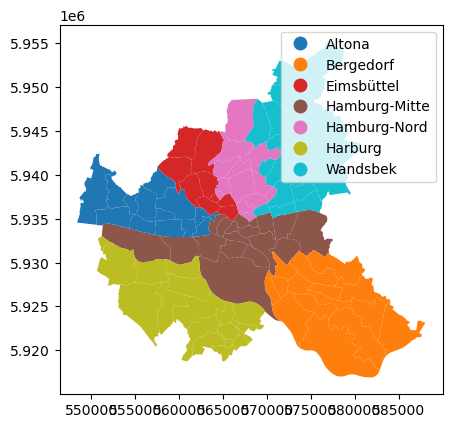

In [12]:
df_districts.plot(column = 'bezirk_nam', legend = True);

In [13]:
df_bezirk = df_districts.dissolve(by = ['bezirk', 'bezirk_nam'], aggfunc = 'sum')

df_bezirk = df_bezirk.reset_index()

df_bezirk['kreis'] = df_bezirk['bezirk'].apply(lambda x: '0' + str(x))

/Users/tobias/opt/miniconda3/envs/geospatial/lib/python3.9/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [14]:
df_bezirk['bezirk_population'] = [300277,275011,269964,315929,444037,130711,170482]
df_bezirk['bezirk_area_sqkm'] = [142.2,77.9,49.8,57.8,147.5,154.8,125.2]
df_bezirk['bezirk_pop_density'] = df_bezirk['bezirk_population'] / df_bezirk['bezirk_area_sqkm']

In [15]:
df_bezirk

bezirk     bezirk_nam                                           geometry  \
0      1  Hamburg-Mitte  POLYGON ((566380.311 5925325.069, 566282.956 5...   
1      2         Altona  POLYGON ((555651.304 5933510.967, 555337.017 5...   
2      3     Eimsbüttel  POLYGON ((565797.903 5934832.877, 565797.458 5...   
3      4   Hamburg-Nord  POLYGON ((564391.545 5937420.714, 564382.192 5...   
4      5       Wandsbek  MULTIPOLYGON (((573346.824 5935754.906, 573342...   
5      6      Bergedorf  POLYGON ((573715.446 5920276.955, 573693.672 5...   
6      7        Harburg  POLYGON ((561453.250 5919328.943, 561178.819 5...   

   OBJECTID     SHAPE_Leng    SHAPE_Area kreis  bezirk_population  \
0       171  356189.118878  3.802713e+08    01             300277   
1       371  275125.594398  2.205236e+08    02             275011   
2       342  163287.748048  1.412220e+08    03             269964   
3       637  215854.420576  1.638548e+08    04             315929   
4      1161  437926.467670  4.189253e+08    05             444037   
5      1127  423615.825507  4.356388e+08    06             130711   
6      1632  394147.600824  3.524963e+08    07             170482   

   bezirk_area_sqkm  bezirk_pop_density  
0             142.2         2111.652602  
1              77.9         3530.308087  
2              49.8         5420.963855  
3              57.8         5465.899654  
4             147.5         3010.420339  
5             154.8          844.386305  
6             125.2         1361.677316

In [16]:
btw_df = df_bezirk.merge(btw_df, on = 'kreis')

In [17]:
btw_df.head()

bezirk     bezirk_nam                                           geometry  \
0      1  Hamburg-Mitte  POLYGON ((566380.311 5925325.069, 566282.956 5...   
1      2         Altona  POLYGON ((555651.304 5933510.967, 555337.017 5...   
2      3     Eimsbüttel  POLYGON ((565797.903 5934832.877, 565797.458 5...   
3      4   Hamburg-Nord  POLYGON ((564391.545 5937420.714, 564382.192 5...   
4      5       Wandsbek  MULTIPOLYGON (((573346.824 5935754.906, 573342...   

   OBJECTID     SHAPE_Leng    SHAPE_Area kreis  bezirk_population  \
0       171  356189.118878  3.802713e+08    01             300277   
1       371  275125.594398  2.205236e+08    02             275011   
2       342  163287.748048  1.412220e+08    03             269964   
3       637  215854.420576  1.638548e+08    04             315929   
4      1161  437926.467670  4.189253e+08    05             444037   

   bezirk_area_sqkm  bezirk_pop_density  ...  die_linke  grüne  sonstige  \
0             142.2         2111.652602  ...      12187  29865     10690   
1              77.9         3530.308087  ...      13667  46162      9344   
2              49.8         5420.963855  ...      10847  47983      8929   
3              57.8         5465.899654  ...      12254  56805     12394   
4             147.5         3010.420339  ...      10865  44989     16132   

    cdu_pct   spd_pct   afd_pct   fdp_pct  die_linke_pct  grüne_pct  \
0  0.108369  0.307959  0.060996  0.091146       0.099713   0.244352   
1  0.147789  0.255531  0.033111  0.108768       0.089858   0.303508   
2  0.148680  0.280055  0.035307  0.113429       0.067639   0.299211   
3  0.137385  0.272308  0.035943  0.126528       0.064365   0.298371   
4  0.190353  0.326639  0.058168  0.125085       0.045243   0.187338   

   sonstige_pct  
0      0.087465  
1      0.061435  
2      0.055679  
3      0.065100  
4      0.067175  

[5 rows x 25 columns]

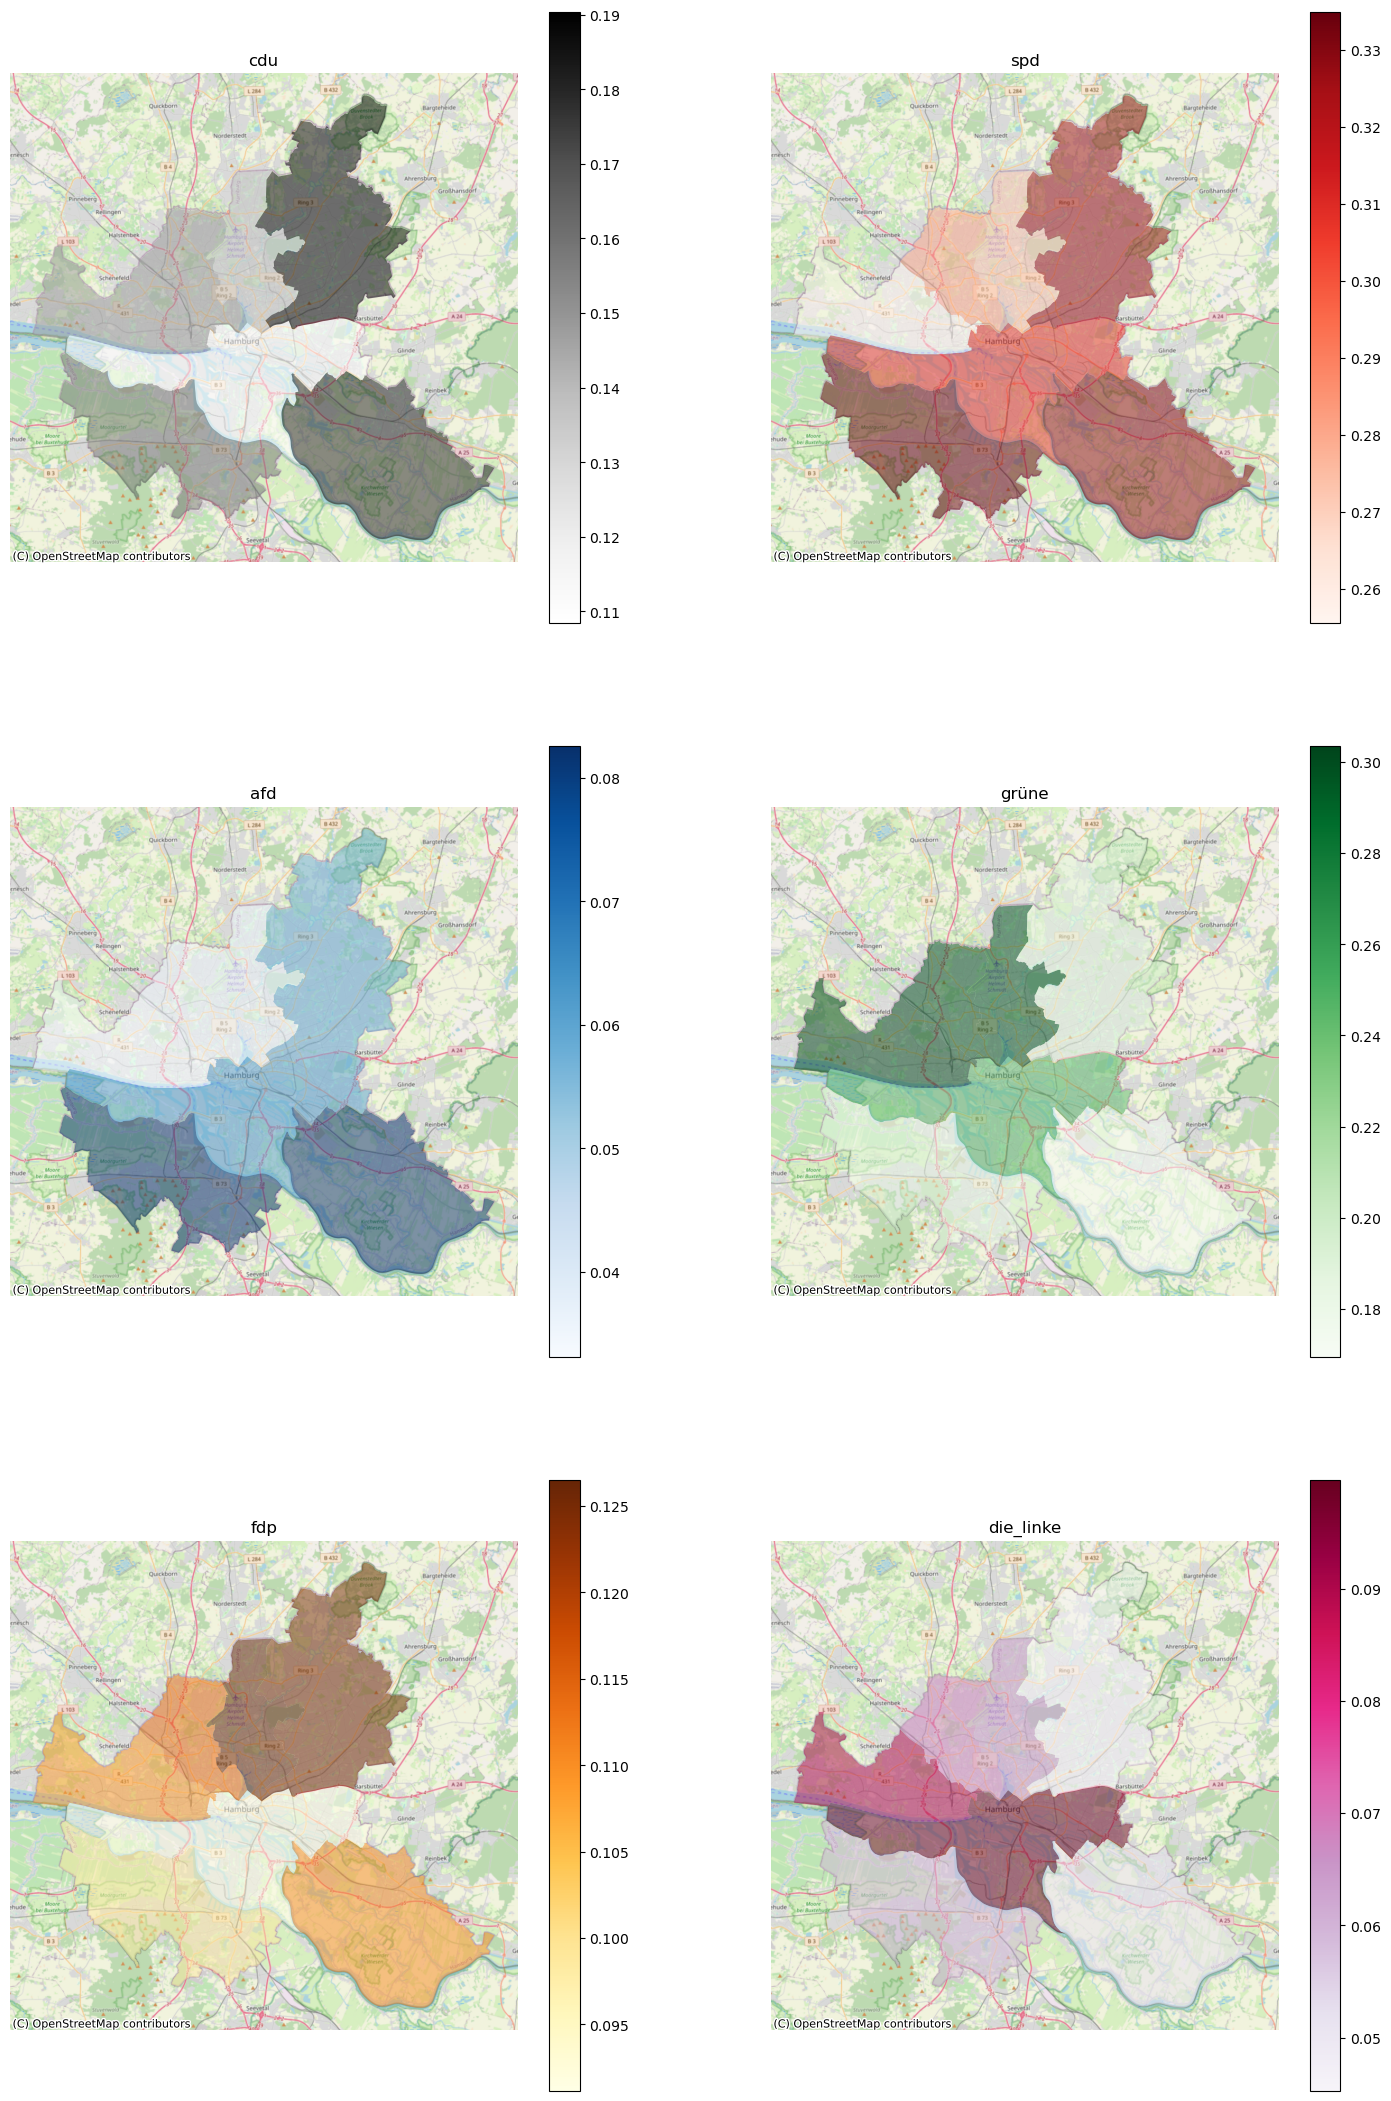

In [18]:
fig, axes = plt.subplots(3,2, figsize=(18, 27))

ax = axes.ravel()

parties = ['cdu', 'spd', 'afd', 'grüne', 'fdp', 'die_linke']

collist = ['Greys', 'Reds', 'Blues', 'Greens', 'YlOrBr', 'PuRd']

for i in range(6):

    btw_df.plot(
        ax=ax[i]
        ,cmap= collist[i]
        ,column = parties[i] + '_pct'
        ,legend = True
        ,alpha = .5
    )
    ax[i].set_title(parties[i])
    ax[i].set_axis_off()

    ctx.add_basemap(
        ax = ax[i]
        ,source=ctx.providers.OpenStreetMap.Mapnik
        ,crs=btw_df.crs.to_string()
    )

plt.show()

# Analysis per district

In [19]:
df_acc_districts = acc_df.sjoin(df_bezirk, how = 'inner', predicate = 'intersects')

df_acc_districts = df_acc_districts.reset_index()

In [20]:
df_acc_districts.head()

index  OBJECTID_left            UIDENTSTLA ULAND UREGBEZ UKREIS UGEMEINDE  \
0     814            815  01210120171013982021    01       0     60       063   
1    6542           6543  02210908000035352700    02       5     14       522   
2  135597         135598  02210225000038000980    02       5     18       526   
3  135608         135609  02210202000038985310    02       5     05       513   
4  135618         135619  02210301000036004110    02       5     07       515   

  UJAHR UMONAT USTUNDE  ... index_right bezirk bezirk_nam OBJECTID_right  \
0  2021     01      11  ...           4      5   Wandsbek           1161   
1  2021     09      14  ...           4      5   Wandsbek           1161   
2  2021     02      09  ...           4      5   Wandsbek           1161   
3  2021     02      13  ...           4      5   Wandsbek           1161   
4  2021     03      14  ...           4      5   Wandsbek           1161   

     SHAPE_Leng    SHAPE_Area kreis bezirk_population bezirk_area_sqkm  \
0  437926.46767  4.189253e+08    05            444037            147.5   
1  437926.46767  4.189253e+08    05            444037            147.5   
2  437926.46767  4.189253e+08    05            444037            147.5   
3  437926.46767  4.189253e+08    05            444037            147.5   
4  437926.46767  4.189253e+08    05            444037            147.5   

  bezirk_pop_density  
0        3010.420339  
1        3010.420339  
2        3010.420339  
3        3010.420339  
4        3010.420339  

[5 rows x 37 columns]

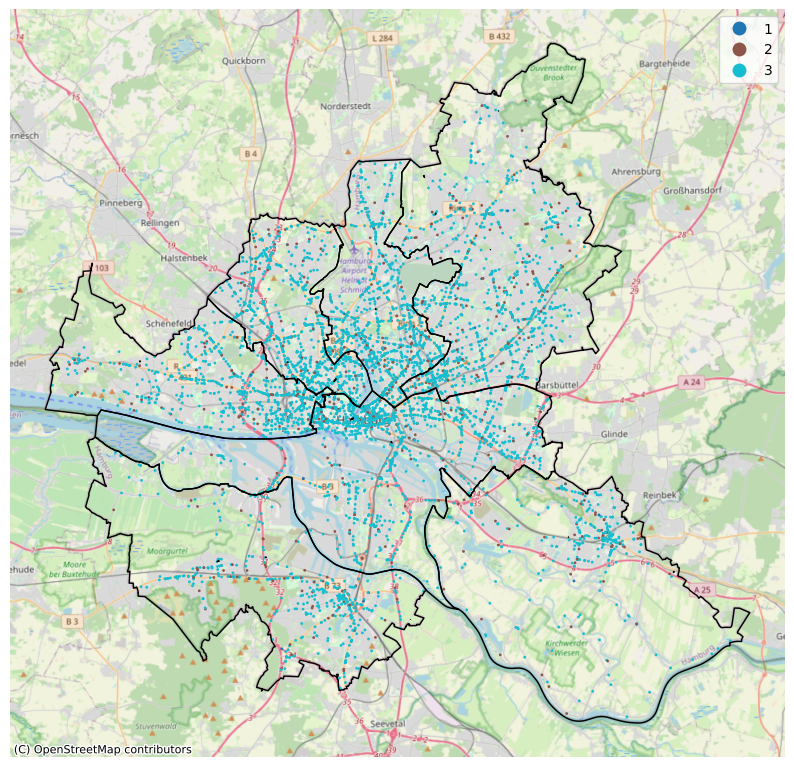

In [21]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
    
df_acc_districts.plot(
    ax = ax
    ,column = 'UKATEGORIE'
    ,markersize = 1
    ,legend = True
    )
    


df_bezirk.plot(
    ax = ax
    ,facecolor="none"
    , edgecolor="black"
    , linewidth=1
)

ax.set_axis_off()

ctx.add_basemap(
    ax = ax
    ,source=ctx.providers.OpenStreetMap.Mapnik
    ,crs=df_acc_districts.crs.to_string()
)

plt.show()

In [22]:
cols = ["UKATEGORIE", "UART", "UTYP1", "ULICHTVERH", "IstPKW", "IstKrad", "IstGkfz", "IstSonstig"]

df_dummies = pd.get_dummies(df_acc_districts.bezirk_nam)
df_dummies.columns = ['altona', 'bergedorf', 'eimsbuttel', 'hh_mitte', 'hh_nord', 'harburg', 'wandsbek']
df_cramersv = pd.concat([df_acc_districts, df_dummies], axis = 1)

In [23]:
df_cramersv.columns

Index(['index', 'OBJECTID_left', 'UIDENTSTLA', 'ULAND', 'UREGBEZ', 'UKREIS',
       'UGEMEINDE', 'UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE',
       'UART', 'UTYP1', 'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad',
       'IstGkfz', 'IstSonstig', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'USTRZUSTAN', 'geometry', 'index_right', 'bezirk', 'bezirk_nam',
       'OBJECTID_right', 'SHAPE_Leng', 'SHAPE_Area', 'kreis',
       'bezirk_population', 'bezirk_area_sqkm', 'bezirk_pop_density', 'altona',
       'bergedorf', 'eimsbuttel', 'hh_mitte', 'hh_nord', 'harburg',
       'wandsbek'],
      dtype='object')

In [24]:
# https://stackoverflow.com/questions/20892799/using-pandas-calculate-cramérs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):

    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [25]:
for col in cols:
    confusion_matrix = pd.crosstab(df_cramersv[col], df_cramersv['bezirk_nam']).to_numpy()
    stat, p, df, expected = ss.chi2_contingency(confusion_matrix)
    #print('{}:\nChi2 crit. val.: {:.2f} (df: {})\nCramer\'s V.: {:.3f}\n'.format(col,stat,df,cramers_corrected_stat(confusion_matrix)))
    print('{}: {:.3f}'.format(col,cramers_corrected_stat(confusion_matrix)))


UKATEGORIE: 0.053
UART: 0.066
UTYP1: 0.053
ULICHTVERH: 0.000
IstPKW: 0.076
IstKrad: 0.000
IstGkfz: 0.119
IstSonstig: 0.029


In [26]:
for col in cols:
    confusion_matrix = pd.crosstab(df_cramersv[col], df_cramersv['UGEMEINDE']).to_numpy()
    stat, p, df, expected = ss.chi2_contingency(confusion_matrix)
    #print('{}:\nChi2 crit. val.: {:.2f} (df: {})\nCramer\'s V.: {:.3f}\n'.format(col,stat,df,cramers_corrected_stat(confusion_matrix)))
    print('{}: {:.3f}'.format(col,cramers_corrected_stat(confusion_matrix)))

UKATEGORIE: 0.025
UART: 0.126
UTYP1: 0.132
ULICHTVERH: 0.049
IstPKW: 0.168
IstKrad: 0.101
IstGkfz: 0.259
IstSonstig: 0.081


Per Bezirk: Basically not effect for all but one category. IstGkfz (accident with lorry) has some association, possible because of the harbour

Per district: More promising, we should see some hotspots for lorries but also cars. UART and UTYP1 also a small association.

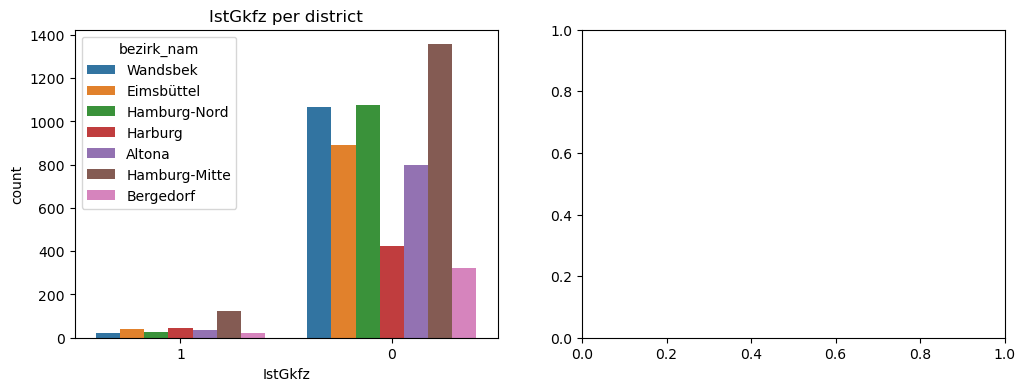

In [27]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

ax = axes.ravel()

print_cols = ["IstGkfz"]

for i in range(len(print_cols)):

    sns.countplot(
        x = print_cols[i]
        ,hue = 'bezirk_nam'
        ,data = df_acc_districts
        ,ax = ax[i]
    )
    ax[i].set_title(print_cols[i] + ' per district')

plt.show()

# Association of cateories

In [28]:
for col1 in cols:
    for col2 in cols:
        confusion_matrix = pd.crosstab(df_cramersv[col1], df_cramersv[col2]).to_numpy()
        stat, p, df, expected = ss.chi2_contingency(confusion_matrix)
        cramersv = cramers_corrected_stat(confusion_matrix)
        if (cramersv >= .1) & (col1 != col2):
            #print('{} ~ {}:\nChi2 crit. val.: {:.2f} (df: {})\nCramer\'s V.: {:.3f}\n'.format(col1,col2,stat,df,cramers_corrected_stat(confusion_matrix)))
            print('{} ~ {}: {:.3f}\n'.format(col1,col2,cramers_corrected_stat(confusion_matrix)))

UKATEGORIE ~ UART: 0.118

UART ~ UKATEGORIE: 0.118

UART ~ UTYP1: 0.670

UART ~ ULICHTVERH: 0.118

UART ~ IstPKW: 0.592

UART ~ IstKrad: 0.135

UART ~ IstGkfz: 0.211

UART ~ IstSonstig: 0.102

UTYP1 ~ UART: 0.670

UTYP1 ~ ULICHTVERH: 0.115

UTYP1 ~ IstPKW: 0.482

UTYP1 ~ IstKrad: 0.123

UTYP1 ~ IstGkfz: 0.193

ULICHTVERH ~ UART: 0.118

ULICHTVERH ~ UTYP1: 0.115

IstPKW ~ UART: 0.592

IstPKW ~ UTYP1: 0.482

IstPKW ~ IstSonstig: 0.282

IstKrad ~ UART: 0.135

IstKrad ~ UTYP1: 0.123

IstGkfz ~ UART: 0.211

IstGkfz ~ UTYP1: 0.193

IstSonstig ~ UART: 0.102

IstSonstig ~ IstPKW: 0.282



# Interactive plot

In [47]:
df_acc_districts.columns

Index(['index', 'OBJECTID_left', 'UIDENTSTLA', 'ULAND', 'UREGBEZ', 'UKREIS',
       'UGEMEINDE', 'UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG', 'UKATEGORIE',
       'UART', 'UTYP1', 'ULICHTVERH', 'IstRad', 'IstPKW', 'IstFuss', 'IstKrad',
       'IstGkfz', 'IstSonstig', 'LINREFX', 'LINREFY', 'XGCSWGS84', 'YGCSWGS84',
       'USTRZUSTAN', 'geometry', 'index_right', 'bezirk', 'bezirk_nam',
       'OBJECTID_right', 'SHAPE_Leng', 'SHAPE_Area', 'kreis',
       'bezirk_population', 'bezirk_area_sqkm', 'bezirk_pop_density'],
      dtype='object')

In [65]:
fig = px.scatter_mapbox(
    df_acc_districts
    ,lat = df_acc_districts.geometry.x
    ,lon = df_acc_districts.geometry.y
    ,hover_name = 'index', hover_data = ['UKATEGORIE']
    #,color = 'UKATEGORIE'
    ,color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()